<h1><center> Web scraping multiple job platforms with Selenium & BeautifulSoup and centralizing results in an interactive Bokeh app </center></h1>

***
<h2><u>Context and objectives</u></h2>

This notebook is focused on a personal project which aims at centralizing in a single app my job searches on several online job boards. To date, in the framework of this project, "only" the APEC and Indeed job websites have been scraped and the job search queries have been restricted to data-related positions in France. 
<br>

This project can be divided into three tasks with distinct purposes. 
<br>
The first chapter of the notebook tackles in details the web scraping exercise with the Python libraries Selenium and BeautifulSoup while the second one is specifically dedicated to the construction of the personal job dashboard using the Bokeh library. Finally, the last task will consist in an exploratory data analysis of all the information collected in order to have an overall picture of the data-related job market in France and enlighten the most valuable and sought-after soft and hard skills.
<br>
<br>
<u>*Key skills:*</u>
<br>
**Unstructured data**, **Web scraping**, **Text mining**, **Dataviz**, **Text similarity metrics**
<br>
<u>*Key libraries:*</u>
<br>
**Selenium**, **BeautifulSoup**, **Bokeh**, **Pandas**, **Re**

***
<h2><u>Table of contents</u></h2>

[<h3>I) Web scraping the job boards</h3>](#1)
[<h4>&emsp;1) Apec job board </h4>](#1.1)

<h2>I) Web scraping the job boards</h2>
<a id="1"></a>

For dynamic web scraping I used the powerful library combination of Selenium and BeautifoulSoup. BeautifoulSoup would be self-sufficient for static scraping but does not handle Javascript components and could not deal with the few necessary event-action for the targeted website (e.g. closing a popup, navigating to next page, scroll down the page to display its full content ...)
<br>
Selenium allows web browser interactions/navigation directly from Python via a chosen web driver and can also fetch the HTML page source for the current DOM of a website. Afterwards, BeautifulSoup can perform the parsing job of the document using a custom parser (here "lxml").
<br>
<br>
For furter information on how to install and use these libraries, please read the available documentations [[1]](#ref1), [[2]](#ref2).
Other usefull contents browsed during my journey through web scraping : [[3]](#ref3), [[4]](#ref4), [[5]](#ref4), [[6]](#ref6), [[7]](#ref7).
<br>
<br>
<u>*Prior to scrape a website, its general terms of use should be checked.*</u>


<h3>1) APEC job board</h3>
<a id="1.1"></a>

<h4>a) Step by step approach</h4>
<a id="1.1.a"></a>

For the APEC job board, the process of retrieving the target information from unstructured data will be presented step by step. Feel free to directly move to the next section if you are already familiar with Selenium and BeautifulSoup. 
<br>
Please not that APEC is a French job board and that some information will be displayed in french.
<br>
<br>
First, let's import all the necessary libaries for the Notebook.

In [107]:
import os
import sys
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)
import glob
import time
import datetime
import random
import re

import selenium
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import Select
from six.moves import urllib
import bs4
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
from IPython.display import display, Image

import bokeh
from bokeh.models.widgets import HTMLTemplateFormatter, DateFormatter
from bokeh.models.widgets import DataTable, TableColumn, RadioButtonGroup, TextInput, TextAreaInput, Dropdown,\
    RangeSlider, CheckboxGroup, Div
from bokeh.models import ColumnDataSource, Panel, Tabs
from bokeh.io import curdoc
from bokeh.layouts import gridplot, column

In [7]:
print("Python version: ", sys.version)
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("Selenium version: ", selenium.__version__)
print("BeautifulSoup version: ", bs4.__version__)
print("Bokeh version: ", bokeh.__version__)

Python version:  3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]
Numpy version:  1.16.4
Pandas version:  0.24.2
Selenium version:  3.141.0
BeautifulSoup version:  4.7.1
Bokeh version:  1.3.0


We need to define and initiate our Selenium web driver. Headless option is removed here in order to see what we are actually doing.

In [60]:
options = webdriver.ChromeOptions()
options.add_argument('--ignore-certificate-errors')
options.add_argument('--incognito')
#options.add_argument('--headless')
driver = webdriver.Chrome(options=options)

In [61]:
some_url = "https://cadres.apec.fr/home/mes-offres-d-emploi.html"
driver.get(some_url)
time.sleep(2)
driver.find_element_by_xpath("//button[@title='Accepter']").click() #cookie popup

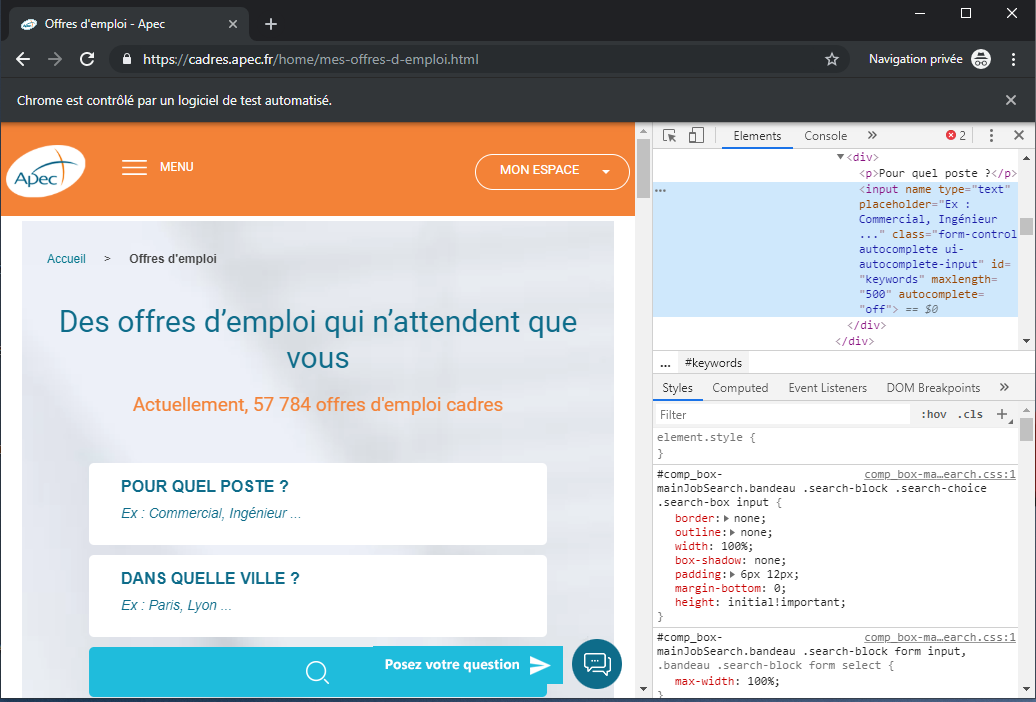

In [27]:
Image(filename='Images/Capture_apec_query.png', height=600, width=600 )

Selenium allows you to find and access elements of a web page according to multiple ways (report to documentation). Here, all we need to do is access to two elements : What position we are looking for and Where. 
<br>
To easily find the proper information to access the different elements : Right click > Inspect element (manually)
<br> 
As mentionned earlier, Selenium replicate all the intereactions a "real end-user" could have with its web brower. Here we clear the two blank fields and enter our proposition. Finally we press Enter Key while being in the location field to initiate our query.

In [62]:
kw_elem = driver.find_element_by_id("keywords")
kw_elem.clear()
kw_elem.send_keys('data scientist OU data analyst')
loc_elem = driver.find_element_by_xpath("//input[@placeholder='Ex : Paris, Lyon ...']")
loc_elem.clear()
loc_elem.send_keys('Auvergne-Rhône-Alpes', Keys.RETURN)

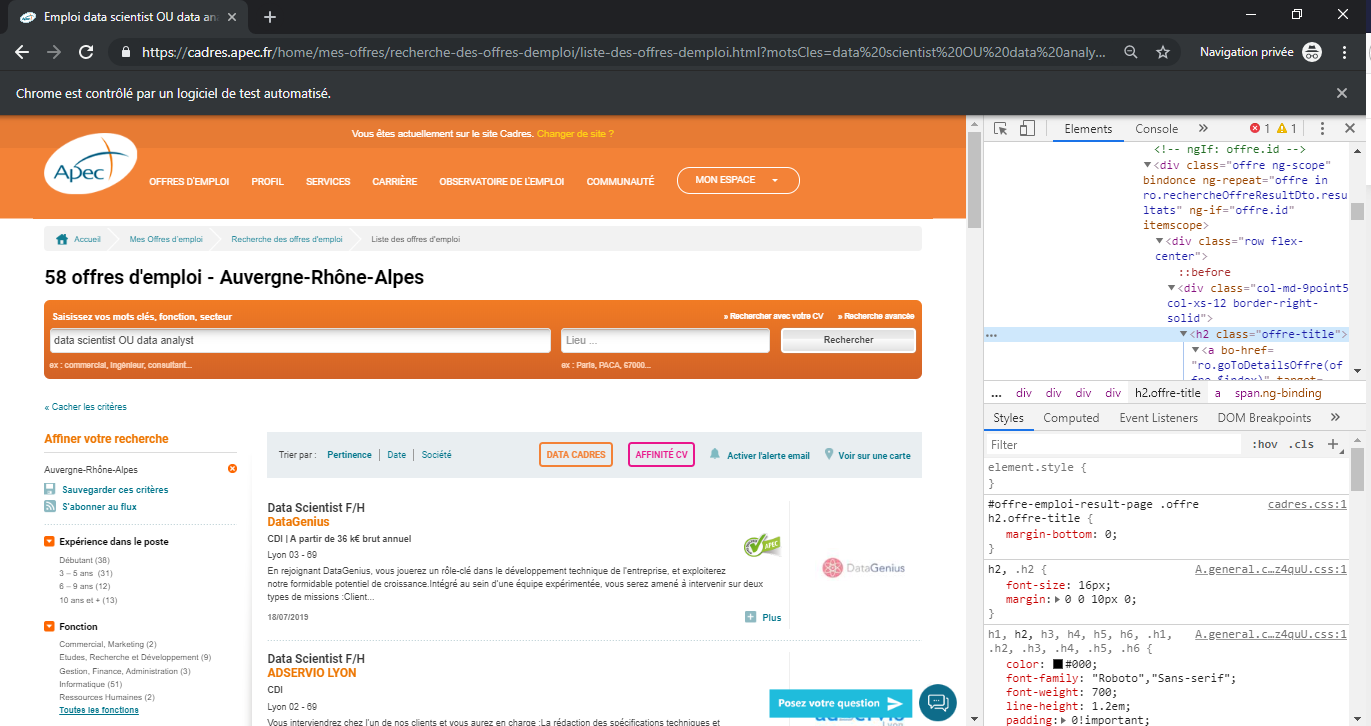

In [34]:
Image(filename='Images/Capture_apec_results.png', height=700, width=700 )

Our next step is to collect all the job offer links returned by our query for every page of results. 
<br>
Just one subtility : to display the "Next" Button to navigate between the pages, we first need to scroll down to the page bottom. 

In [63]:
page_nb = 1
job_links = []
while True:
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    job_titles = driver.find_elements_by_class_name('offre-title')
    for i in range(len(job_titles)):
        job_link = job_titles[i].find_element_by_css_selector('a').get_attribute('href')
        job_links.append(job_link)
    try:
        next_page = driver.find_element_by_link_text('Suiv.').click()
        page_nb += 1
        print("Navigating to next page ({})".format(page_nb))
    except:
        print("\n All the pages ({}) have been read through".format(page_nb))
        break

Navigating to next page (2)
Navigating to next page (3)

 All the pages (3) have been read through


In [67]:
len(job_links)

59

Everything seems fine. We are almost done with Selenium. 
<br> 
The last action consists in fetching the source code of every webpage stored in our job_links list. Let's move on to the parsing exercise with BeautifulSoup. As adviced by the documentation, I installed and used the lxml parser for speed.

In [68]:
some_offer = job_links[0]
driver.get(some_offer)
page_source = driver.page_source

In [69]:
soup = BeautifulSoup(page_source, 'lxml')

BeautifoulSoup provides a lot of means and alternatives to navigate through the DOM and retrieve the desired elements. Please, read the documentation for further information on how navigating/searching the tree and manipulating the different kind of objects. Like for Selenium, left-click > Inspect element, will be our best option to identify the target information.

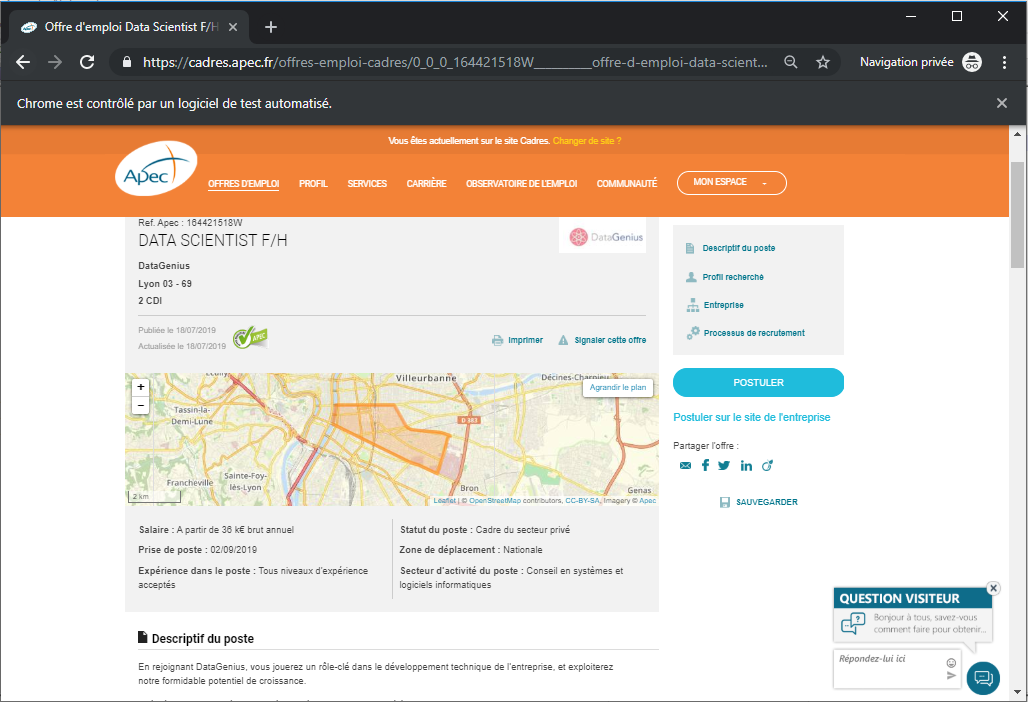

In [70]:
Image(filename='Images/Capture_apec_offer.png', height=700, width=700 )

In [80]:
ref = soup.find(string=re.compile('Ref\. Apec'))
re.findall("\d+\w*", ref)[0]

'164421518W'

In [81]:
job_title = soup.find('h1', class_="text-uppercase ng-binding").text
job_title

'Data Scientist F/H'

In [82]:
comp_and_loc = soup.find_all('strong', class_="ng-binding")
compagny, location = comp_and_loc[1].text, comp_and_loc[2].text
compagny, location

('DataGenius', 'Lyon 03 - 69')

In [83]:
pos_type = soup.find('span', class_="ng-binding ng-scope").text
nb_pos = next(soup.find('span', class_="ng-binding ng-scope").parent.stripped_strings)
pos_type, nb_pos

('CDI', '2')

In [84]:
pub_date = re.findall("(?:/*\\d+)+", soup.find(string=re.compile('Publiée le')))[0]
act_date = re.findall("(?:/*\\d+)+", soup.find(string=re.compile('Actualisée le')))[0]
pub_date, act_date

('18/07/2019', '18/07/2019')

BeautifulSoup also accepts function for tag. Here we want to retrieve all "strong" tag objects with no "class" attribute. 

In [92]:
def tag_strong_but_no_class(tag):
    return (tag.name == "strong") and not(tag.has_attr('class'))

In [93]:
full_info = soup.find_all(tag_strong_but_no_class)
full_info

[<strong>Salaire :</strong>,
 <strong>Prise de poste :</strong>,
 <strong>Expérience dans le poste :</strong>,
 <strong>Statut du poste :</strong>,
 <strong>Zone de déplacement :</strong>,
 <strong>Secteur d’activité du poste :</strong>,
 <strong>Client :</strong>,
 <strong>R&amp;D :</strong>,
 <strong>DataGenius</strong>,
 <strong>Intelligence Artificielle</strong>,
 <strong>Machine Learning et Big Data</strong>,
 <strong>Data Science et Intelligence Artificielle sont au cœur d'une rupture sociétale et économique majeure</strong>,
 <strong>start-up dynamique et bienveillante</strong>,
 <strong>porteuse de projets stimulants et innovants</strong>,
 <strong>Personne en charge du recrutement :</strong>]

In [94]:
full_info[0].next_sibling

' A partir de 36 k€ brut annuel'

In [95]:
relevant_info_l = ['salary', 'empl_date', 'req_exp', 'pos_stt', 'btrip_area', 'act_area']
relevant_info_d = {}
for idx, info in enumerate(relevant_info_l):
    relevant_info_d[info] = full_info[idx].next_sibling
    
relevant_info_d['req_exp']

" Tous niveaux d'expérience acceptés"

Now we will retrieve the longer text objects for the description of the position, the required profile, the entreprise and the recruitment process. Let's first try with the position description and then build a function to retrieve all these elements.

In [100]:
pos_descr = soup.find(id='descriptif-du-poste')
pos_descr_txt = "\n".join(pos_descr.stripped_strings) #generator
print(pos_descr_txt)

Descriptif du poste
En rejoignant DataGenius, vous jouerez un rôle-clé dans le développement technique de l’entreprise, et exploiterez notre formidable potentiel de croissance.
Intégré au sein d’une équipe expérimentée, vous serez amené à intervenir sur deux types de missions :
Client :
Vous participerez à la mise en place de modèles de machine et deep Learning pour des clients, les tester et les mettre en production. Vous serez amené à vous adapter aux problématiques et au métier des clients, mais aussi faire preuve d’une autonomie dans l’analyse des données qui vous seront fournis et la mise en place d’un modèle qui répond aux objectifs qui vous seront définis.
R&D :
Vous contribuerez au développement des différents modules de​ Atlas (NLP, Auto-ML, exploitation de l’Open Data, mise en place d’API, etc.) :
Effectuer une étude bibliographique sur l'état de l’art concernant le module choisi
Proposer une solution adéquate
Définir le protocole expérimental (les données à utiliser, la fonc

In [106]:
def fetch_txt_from_soup(id_txt, soup):
    """Take a soup object and an id and return the full text corresponding to the section"""
    elem = soup.find(id=id_txt)
    if elem != None:
        elem_txt = "\n".join(elem.stripped_strings) #generator
        if id_txt == 'entreprise': #noisy text
            elem_txt = re.sub("\nAutres offres de l'entreprise", '', elem_txt)
        elif id_txt == 'processus-de-recrutement': #noisy text
            elem_txt = re.sub('\n?.*POSTULER.*\nImprimer\nSignaler cette offre', '', 
                              elem_txt)
        return elem_txt
    else:
        return ''

In [107]:
id_in_l = ['descriptif-du-poste', 'profil-recherche', 'entreprise', 'processus-de-recrutement']
id_out_l = ['pos_descr', 'profil', 'comp_info', 'recruit_proc']

for id_in, id_out in zip(id_in_l, id_out_l):
    relevant_info_d[id_out] = fetch_txt_from_soup(id_in, soup)

In [109]:
print(relevant_info_d['profil'])

Profil recherché
De niveau Bac+4/5 ou équivalent en école d'ingénieur, vous possédez une spécialisation en mathématiques appliquées, statistiques, machine learning ou intelligence artificielle.
Vous affichez des capacités à manipuler et traiter des données en provenance de sources diverses.
Vous démontrez du goût pour la résolution de problèmes par des approches quantitatives en se formant sur des techniques avancées de Machine Learning.
Vous avez la volonté de rejoindre une aventure entrepreneuriale avec une équipe ambitieuse, tournée vers l’innovation.
Une bonne maîtrise de l’anglais est indispensable.
Vous maîtrisez l'utilisation de  Git, Python (Scikit-learn, Numpy, Pandas, Keras, Tensorflow) et optionnellement Linux, Docker, Django, Spark.


And finally, the recruitment responsible (if provided).

In [112]:
elem = soup.find('i')
try:
    recruit_resp = elem.previous_element + elem.text
except Exception as e:
    print(e)
    recruit_resp=''

recruit_resp

'Taha Zemmouri - Président'

***
**This is pretty much everything we need to do to scrap the APEC job board.
<br> The only thing left is to define some nice functions to proceed the whole step by step approach and build our own job database.**

<h4>b) All in one functions</h4>
<a id="1.1.b"></a>

Let's define 3 main functions to handle the full web scraping process and build our own databe :
* 1st : initiate the webdrive and request the job platform on position key words and location and precise a sorting option for the result;
* 2nd : take the driver returned by the first function and browse all the result pages to fetch the URL of every job offer;
* 3rd : load source code of every web page provided by the second function, scrape it with BeautifulSoup and store the information in a list of dictionnaries (in anticipation of the coming dataframe). 

Nothing special to mention for these 3 functions in comparison to the previous step by step presentation. I just added some time.sleep() in the code because of a few erros I encountered while dealing with bigger data. This prevents server overwhelming, allows the page to fully load/wait for a specific element to appear.

In [9]:
ROOT_URL = "https://cadres.apec.fr/home/mes-offres-d-emploi.html"
JOB_KW = "data scientist OU data analyst"

In [10]:
DB_SAVING_DIR = './job_db'
os.makedirs(DB_SAVING_DIR, exist_ok=True)
DB_APEC_SAVING_PATH = os.path.join(DB_SAVING_DIR, 'apec_db.xlsx')

In [114]:
def request_apec_platform(root_url=ROOT_URL, job_kw=JOB_KW, job_loc=None,
                          sort_by='Pertinence'):
    """Initiate the webdrive and request the job platform on position key words and location and
    precise a sorting option for the result"""
    global driver
    try:
        driver.quit()
    except:
        pass
    options = webdriver.ChromeOptions()
    options.add_argument('--ignore-certificate-errors')
    options.add_argument('--incognito')
    options.add_argument('--headless')
    options.add_argument("--window-size=1366, 768")
    driver = webdriver.Chrome(options=options)
    driver.get(root_url)
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(2)
    try:
        driver.find_element_by_xpath("//button[@title='Accepter']").click() #cookie popup
        time.sleep(2)
    except:
        pass
    kw_elem = driver.find_element_by_id("keywords")
    kw_elem.clear()
    kw_elem.send_keys(job_kw)
    if job_loc != None:
        loc_elem = driver.find_element_by_xpath("//input[@placeholder='Ex : Paris, Lyon ...']")
        loc_elem.clear()
        loc_elem.send_keys(job_loc, Keys.RETURN)
    else:
        driver.find_element_by_class_name('btn-block').click()
    sort_by_el = driver.find_element_by_link_text(sort_by)
    sort_by_el.click()
    print("Job search request was performed on:\n"
          "Job title: {}, Job location: {}, sorted by {}".format(job_kw, job_loc, sort_by))
    return driver

In [52]:
def fetch_apec_job_links(driver=driver, old_db_path=DB_APEC_SAVING_PATH, 
                           max_consec_existing_link=40):
    """Take the driver request and browse all the result pages to fetch the URL of every job offer"""
    page_nb = 1
    job_links = []
    consec_existing_link = 0
    update = os.path.isfile(old_db_path)
    if update is True:
        print('A previous database already exists. Only new job links will be fetched')
        old_db = pd.read_excel(old_db_path)
        old_job_links = old_db['url'].to_list()
    while True:
        time.sleep(1)
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(1)
        job_titles = driver.find_elements_by_class_name('offre-title')
        for i in range(len(job_titles)):
            job_link = job_titles[i].find_element_by_css_selector('a').get_attribute('href')
            job_link = re.split('&totalCount', job_link)[0]
            if (update is False) or (job_link not in old_job_links):
                job_links.append(job_link)
                consec_existing_link = 0
            else:
                consec_existing_link += 1
                if consec_existing_link >= max_consec_existing_link:
                    print("\nNo more new links to retrieve")
                    break  
        try:
            assert consec_existing_link < max_consec_existing_link
            next_page = driver.find_element_by_link_text('Suiv.').click()
            page_nb += 1
            print("Navigating to next page ({})".format(page_nb))
        except:
            print("\nAll the pages ({}) have been read through".format(page_nb))
            break
    return job_links

In [118]:
def scrapping_apec_offers(job_links, parser='lxml', LIMIT=None):
    """Load source code of every web page from the URL job_links list, scrape it with BeautifulSoup 
    and store the information in a list of dictionnaries"""
    global driver
    try:
        driver.quit()
    except:
        pass
    options = webdriver.ChromeOptions()
    options.add_argument('--ignore-certificate-errors')
    options.add_argument('--incognito')
    options.add_argument('--headless')
    options.add_argument("--window-size=1366, 768")
    driver = webdriver.Chrome(options=options)
    job_parser_l = []
    relevant_info_l = ['salary', 'empl_date', 'req_exp', 'pos_stt', 'btrip_area', 'act_area']
    id_in_l = ['descriptif-du-poste', 'profil-recherche', 'entreprise', 
               'processus-de-recrutement']
    id_out_l = ['pos_descr', 'profil', 'comp_info', 'recruit_proc']
    for x, link in enumerate(job_links[:LIMIT]):
        size = len(job_links)
        if x % 100 == 0:
            print('\n{} offers have been parsed out of {}'.format(x, size))
        try:
            job_parser_d = {}
            driver.get(link)
            page_source = driver.page_source
            soup = BeautifulSoup(page_source, parser)
            ref = soup.find(string=re.compile('Ref\. Apec'))
            job_parser_d['ref_site'] = re.findall("Ref. Apec : (\d*\w*)", ref)[0]
            ref = soup.find(string=re.compile('Ref\. Société'))
            if ref != None:
                job_parser_d['ref_comp'] = re.findall("Ref. Société : (\d*\w*)", ref)[0]
            else:
                job_parser_d['ref_comp'] = ''
            job_title = soup.find('h1', class_="text-uppercase ng-binding").text
            job_parser_d['job_title'] = re.sub(' F/H', '', job_title)
            comp_and_loc = soup.find_all('strong', class_="ng-binding")
            job_parser_d['company'] = comp_and_loc[1].text
            job_parser_d['location'] = comp_and_loc[2].text
            pos_type = soup.find('span', class_="ng-binding ng-scope")
            job_parser_d['pos_type'] = pos_type.text
            job_parser_d['nb_pos'] = next(pos_type.parent.stripped_strings)
            pub_date = re.findall("(?:/*\\d+)+", soup.find(string=re.compile('Publiée le')))[0]
            job_parser_d['pub_date'] = pub_date
            act_date = re.findall("(?:/*\\d+)+", soup.find(string=re.compile('Actualisée le')))[0]
            job_parser_d['act_date'] = act_date
            pos_info = soup.find_all(tag_strong_but_no_class)
            for idx, info in enumerate(relevant_info_l):
                job_parser_d[info] = pos_info[idx].next_sibling            
            for id_in, id_out in zip(id_in_l, id_out_l):
                job_parser_d[id_out] = fetch_txt_from_soup(id_txt=id_in, soup=soup)
            recruiter = soup.find('i')
            try:
                recruit_resp = recruiter.previous_element + recruiter.text
            except :
                recruit_resp = ''
            job_parser_d['recruit_resp'] = recruit_resp
            job_parser_d['url'] = link
                        
            job_parser_l.append(job_parser_d)
        except:
            print('\n', '~-'*20, 'WARNING', '~-'*20,
            '\nAn issue was encountered with an offer. It might probably be no longer'
                ' available at the parsing time.',
            '\nAs a result this offer could not be added to the database. '
            'You should investigate job_link number {}'.format(x),
            '\n', '~-'*20, 'WARNING', '~-'*20)
    print("\nAll the offers have been processed")
    return job_parser_l

Finally, wrap these three functions into one to perform the full web scraping process and create/update the APEC job database. Here I chose to work with a simple Excel file but a real relational database could be a better option.

In [120]:
def update_apec_db(db_path=DB_APEC_SAVING_PATH):
    """Perform the full web scraping process and create/update the APEC database"""
    driver = request_apec_platform(sort_by='Date')
    time.sleep(1)
    job_links_new = fetch_apec_job_links(driver=driver, old_db_path=db_path)
    print('{} new offers were founded and will be parsed'.format(len(job_links_new)))
    new_job_parser = scrapping_apec_offers(job_links=job_links_new)
    df_apec_new = pd.DataFrame(new_job_parser)
    update = os.path.isfile(db_path)
    if update:
        df_apec_db = pd.read_excel(db_path)
        df_apec_full = df_apec_db.append(df_apec_new, ignore_index=True)
        with pd.ExcelWriter(db_path, options={'strings_to_urls': False}) as writer:
            df_apec_full.to_excel(writer, index=False)
    else:
        with pd.ExcelWriter(db_path, options={'strings_to_urls': False}) as writer:
            df_apec_new.to_excel(writer, index=False)
    print('\nDone: the new offers were added to the APEC DB')
    return df_apec_full

In [121]:
df_apec_full = update_apec_db()

Job search request was performed on:
Job title: data scientist OU data analyst, Job location: None, sorted by Date
A previous database already exists. Only new job links will be fetched
Navigating to next page (2)
Navigating to next page (3)
Navigating to next page (4)
Navigating to next page (5)
Navigating to next page (6)
Navigating to next page (7)

No more new links to retrieve

All the pages (7) have been read through
45 new offers were founded and will be parsed

0 offers have been parsed out of 45

All the offers have been processed

Done: the new offers were added to the APEC DB


In [124]:
display(df_apec_full.head())

,act_area,act_date,btrip_area,comp_info,company,empl_date,job_title,location,nb_pos,pos_descr,...,pos_type,profil,pub_date,recruit_proc,recruit_resp,ref_comp,ref_site,req_exp,salary,url
0,Conseil pour les affaires et autres conseils ...,15/05/2019,Pas de déplacement,Entreprise\nNous cherchons pour notre client d...,MINEO,Dès que possible,Data Analyst/Scientist,Aix-en-Provence - 13,1,Descriptif du poste\nAmené à travailler sur de...,...,CDI,Profil recherché\nDe ce fait nous recherchons ...,11/04/2019,Processus de recrutement\nPersonne en charge d...,Grégoire CLEMENT - Founder,NaN,164141813W,Minimum 3 ans,A partir de 40 k€ brut annuel,https://cadres.apec.fr/offres-emploi-cadres/0_...
1,Conseil en systèmes et logiciels informatiques,15/05/2019,Départementale,Entreprise\nModis recrute 1000 Talents en 2019...,MODIS FRANCE,Dès que possible,Consultant Data analyst / Data scientist,Toulouse - 31,1,Descriptif du poste\nVous souhaitez côtoyer au...,...,CDI,Profil recherché\nDe formation Bac+5/ Ingénieu...,15/05/2019,Processus de recrutement\nPersonne en charge d...,Lory Lo Moro - Recruteur,MID,164236918W,Minimum 1 an,A négocier,https://cadres.apec.fr/offres-emploi-cadres/0_...
2,Autre mise à disposition de ressources humaines,03/06/2019,Départementale,Entreprise\nNous sommes un cabinet de conseil ...,ATHANOR INFORMATIQUE,Dès que possible,DATA ANALYST / DATA SCIENTIST,Suresnes - 92,1,Descriptif du poste\nData Analyst/ Data Scient...,...,CDI,Profil recherché\nData Analyst/ Data Scientist...,03/06/2019,Processus de recrutement\nNous recevrons les c...,THIERRY JOUDELAT - Direction,DATA,164266817W,Minimum 2 ans,A négocier,https://cadres.apec.fr/offres-emploi-cadres/0_...
3,Conseil pour les affaires et autres conseils ...,29/05/2019,Pas de déplacement,Entreprise\nEasy Partner fait aujourd'hui part...,EASY PARTNER,Dès que possible,Data Scientist,Paris 02 - 75,1,Descriptif du poste\nLa société :\nNotre clien...,...,CDI,Profil recherché\nLe profil :\nVous maîtrisez ...,29/05/2019,Processus de recrutement\nPersonne en charge d...,. Masson - Consultant en recrutement,NaN,164259645W,Minimum 1 an,40 - 45 k€ brut annuel,https://cadres.apec.fr/offres-emploi-cadres/0_...
4,Conseil pour les affaires et autres conseils ...,29/05/2019,Régionale,"Entreprise\nDu plaisir à faire son travail, da...",SIDERLOG,Dès que possible,Data Scientist,Niort - 79,1,Descriptif du poste\nPour renforcer son équipe...,...,CDI,"Profil recherché\nDe formation décisionnelle, ...",29/05/2019,Processus de recrutement\nPersonne en charge d...,Françoise LEGER - Assistante chargée de recrut...,Data,164279571W,Minimum 5 ans,A négocier,https://cadres.apec.fr/offres-emploi-cadres/0_...


In [125]:
display(df_apec_full.tail())

,act_area,act_date,btrip_area,comp_info,company,empl_date,job_title,location,nb_pos,pos_descr,...,pos_type,profil,pub_date,recruit_proc,recruit_resp,ref_comp,ref_site,req_exp,salary,url
1785,Autres assurances,12/08/2019,Pas de déplacement,Entreprise\nIntériale est l'un des leaders de ...,MUTUELLE INTERIALE,Dès que possible,DATA ANALYST SENIOR en CDI à PARIS,Paris 09 - 75,1,"Descriptif du poste\nVous participez, entre au...",...,CDI,Profil recherché\nVous êtes diplômé Bac +5 en ...,12/08/2019,,,talentplug,164467129W,Minimum 5 ans,A partir de 50 k€ brut annuel,https://cadres.apec.fr/offres-emploi-cadres/0_...
1786,"Ingénierie, études techniques",11/08/2019,Pas de déplacement,Entreprise\nQUI SOMMES-NOUS ?\nThales propose ...,Thales Services S.A.S.,Dès que possible,Ingénieur Système DevOps,Vélizy-Villacoublay - 78,1,Descriptif du poste\nCE QUE NOUS POUVONS ACCOM...,...,CDI,Profil recherché\nQUI ETES-VOUS ?\nLa force de...,11/08/2019,,,R0062632,164475706W,Minimum 2 ans,A négocier,https://cadres.apec.fr/offres-emploi-cadres/0_...
1787,"Ingénierie, études techniques",11/08/2019,Pas de déplacement,Entreprise\nQUI SOMMES-NOUS ?\nThales propose ...,Thales Services S.A.S.,Dès que possible,Ingénieur(e) Java / Big Data,Vélizy-Villacoublay - 78,1,Descriptif du poste\nCE QUE NOUS POUVONS ACCOM...,...,CDI,Profil recherché\nQUI ETES-VOUS ?\nDe formatio...,11/08/2019,,,R0062635,164475705W,Minimum 2 ans,A négocier,https://cadres.apec.fr/offres-emploi-cadres/0_...
1788,"Ingénierie, études techniques",11/08/2019,Pas de déplacement,Entreprise\nQUI SOMMES-NOUS ?\nThales propose ...,Thales Services S.A.S.,Dès que possible,Ingénieur(e) Big Data confirmé,Vélizy-Villacoublay - 78,1,Descriptif du poste\nCE QUE NOUS POUVONS ACCOM...,...,CDI,Profil recherché\nQUI ETES-VOUS ?\nDe formatio...,11/08/2019,,,R0062085,164475698W,Minimum 2 ans,A négocier,https://cadres.apec.fr/offres-emploi-cadres/0_...
1789,Commerce de gros (commerce interentreprises) ...,11/08/2019,Pas de déplacement,"Entreprise\nLa Société BGI DISTRIBUTION,\nFili...",BGI DISTRIBUTION,Dès que possible,Technicien Logistique,Damparis - 39,1,Descriptif du poste\nRattaché au responsable q...,...,CDI,Profil recherché\nDe formation BAC +3 à 5 (typ...,11/08/2019,Processus de recrutement\nConseils\nCV + LM\nP...,Amélie TESTE DE SAGEY - RRH Adjointe,,164475608W,Tous niveaux d'expérience acceptés,A négocier,https://cadres.apec.fr/offres-emploi-cadres/0_...


<h3>2) Indeed job board</h3>
<a id="1.2"></a>

<h4>a) Step by step approach</h4>
<a id="1.2.a"></a>

The step by step process for the Indeed jo board would basically alike the one for the APEC job board (even much simpler since the indeed offers contain less info and are not as well organised). Let's directly move to the all in one chapter. 
<br> 
Please not that I use the French site version for Indeed and that a few information might be in french too.

<h4>b) All in one functions</h4>
<a id="1.2.b"></a>

Exactly like for the APEC job board, let's define 3 main functions to handle the full web scraping process and build our own databe :
* 1st : initiate the webdrive and request the job platform on position key words and location and precise a sorting option for the result;
* 2nd : take the driver returned by the first function and browse all the result pages to fetch the URL of every job offer;
* 3rd : load source code of every web page provided by the second function, scrape it with BeautifulSoup and store the information in a list of dictionnaries (in anticipation of the coming dataframe). 

Here too I added some time.sleep() in the code because of a few erros I encountered while dealing with bigger data. This prevents server overwhelming, allows the page to fully load/wait for a specific element to appear.

In [11]:
ROOT_URL = "https://www.indeed.fr/advanced_search"
JOB_KW = "data" # allow to scrap on job title on Indeed :)
JOB_LOC = 'France'
NB_PER_PAGE = '50'
DB_INDEED_SAVING_PATH = os.path.join(DB_SAVING_DIR, 'indeed_db.xlsx')

In [131]:
def request_indeed_platform(root_url=ROOT_URL, job_kw=JOB_KW, job_loc=None, 
                            lim=NB_PER_PAGE, sort_by='pertinence'):
    """Initiate the webdrive and request the job platform on position key words and location and
    precise a sorting option for the result"""
    global driver
    try:
        driver.quit()
    except:
        pass
    options = webdriver.ChromeOptions()
    options.add_argument('--ignore-certificate-errors')
    options.add_argument('--incognito')
    #options.add_argument('--headless')
    #options.add_argument("--window-size=1366, 768")
    driver = webdriver.Chrome(options=options)
    driver.get(root_url)
    try:   
        driver.find_element_by_css_selector("[class='tos-Button tos-Button-white']").click()
        time.sleep(1)
    except:
        pass 
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    kw_elem = driver.find_element_by_id("as_ttl")
    kw_elem.clear()
    kw_elem.send_keys(job_kw)
    nb_per_page = Select(driver.find_element_by_id('limit'))
    nb_per_page.select_by_visible_text(lim)
    sort_by_el = Select(driver.find_element_by_id('sort'))
    sort_by_el.select_by_visible_text(sort_by)
    if job_loc != None:
        loc_elem = driver.find_element_by_id("where")
        loc_elem.clear()
        loc_elem.send_keys(job_loc, Keys.RETURN)
    else:
        driver.find_element_by_id('fj').click()
    print("Job search request was performed on:\n"
          "Job title: {}, Job location: {}, sorted by {}".format(job_kw, job_loc, sort_by))
    return driver

In [132]:
def fetch_indeed_job_links(driver=driver, old_db_path=DB_INDEED_SAVING_PATH, 
                           max_consec_existing_link=40):
    """Take the driver request and browse all the result pages to fetch the URL of every job offer"""
    page_nb = 1
    job_links = []
    consec_existing_link = 0
    update = os.path.isfile(old_db_path)
    if update is True:
        print('A previous database already exists. Only new job links will be fetched')
        old_db = pd.read_excel(old_db_path)
        old_job_links = old_db['url'].to_list()
    while True:
        time.sleep(random.randint(10, 30))
        try:
            popup = driver.find_element_by_class_name('icl-CloseButton')
            popup.click() #close popup
        except:
            pass
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        job_titles = driver.find_elements_by_class_name("title")
        for i in range(len(job_titles)):
            job_link = job_titles[i].find_element_by_css_selector('a').get_attribute('href')
            if (update is False) or (job_link not in old_job_links):
                job_links.append(job_link)
                consec_existing_link = 0
            else:
                consec_existing_link += 1
                if consec_existing_link >= max_consec_existing_link:
                    print("\nNo more new links to retrieve")
                    break  
        try:
            assert consec_existing_link < max_consec_existing_link
            next_page = driver.find_element_by_link_text('Suivant »').click()
            page_nb += 1
            print("Navigating to next page ({})".format(page_nb))
        except:
            print("\nAll the pages ({}) have been read through".format(page_nb))
            break
    return job_links

In [133]:
def indeed_delta_to_date(soup):
    """Change the Indeed very unconvenient delta date (e.g : "One hour ago", "two weeks ago") into a classic one"""
    job_age = soup.find("div", class_='jobsearch-JobMetadataFooter').text
    if job_age == None:
        return ''
    else:
        digits = re.findall('(\d+)\+?\s(?:jours?|heures?|mois?)', job_age)[0]
        now = datetime.datetime.now()
        match = re.search('heure', job_age)
        if match != None:
            date = now - datetime.timedelta(hours=int(digits))
        elif re.search('jour', job_age) != None:
            date = now - datetime.timedelta(days=int(digits))
        else:
            date = now - datetime.timedelta(days=30)
        return date.strftime('%d/%m/%Y')

In [134]:
def scrapping_indeed_offers(job_links, parser='lxml', LIMIT=None):
    """Load source code of every web page from the URL job_links list, scrape it with BeautifulSoup 
    and store the information in a list of dictionnaries"""
    icons_l = ['icl-IconFunctional icl-IconFunctional--location icl-IconFunctional--md',
               'icl-IconFunctional icl-IconFunctional--jobs icl-IconFunctional--md',
               'icl-IconFunctional icl-IconFunctional--salary icl-IconFunctional--md']
    att_out_l = ['location', 'pos_type', 'salary']
    job_parser_l = []
    while True:
        global driver
        try:
            driver.quit()
        except:
            pass
        options = webdriver.ChromeOptions()
        options.add_argument('--ignore-certificate-errors')
        options.add_argument('--incognito')
        #options.add_argument('--headless')
        #options.add_argument("--window-size=1366, 768")
        driver = webdriver.Chrome(options=options)
        some_link = job_links[random.randint(0, len(job_links))]
        driver.get(some_link)
        page_source = driver.page_source
        soup = BeautifulSoup(page_source, parser)
        elem = soup.find(class_=icons_l[0])
        if elem == None:
            print('Webpage not displayed correctly, restarting the web driver')
        else:
            print('\nWebpage displayed correctly, parsing will start... :)')
            break
   
    for x, link in enumerate(job_links[:LIMIT]):
        size = len(job_links)
        if x % 100 == 0:
            print('\n{} offers have been parsed out of {}'.format(x, size))
        try:
            job_parser_d = {}
            driver.get(link)
            page_source = driver.page_source
            soup = BeautifulSoup(page_source, parser)
            job_title = soup.find('h3').text
            job_parser_d['job_title'] = re.sub('\s+[-(]?\s?(?:F/H|H/F)\)?', '', 
                                               job_title, flags=re.IGNORECASE)
            comp = soup.find('div', class_='icl-u-lg-mr--sm icl-u-xs-mr--xs')
            job_parser_d['company'] = comp.text
            for icon, att_out in zip(icons_l, att_out_l):
                elem = soup.find(class_=icon)
                if elem!=None:
                    job_parser_d[att_out] = elem.next_sibling.text
                else:
                    job_parser_d[att_out] = ''
            pos_descr = soup.find(id='jobDescriptionText')
            job_parser_d['pos_descr'] = pos_descr.text
            job_parser_d['pub_date'] = indeed_delta_to_date(soup=soup)
            job_parser_d['url'] = link                     
            job_parser_l.append(job_parser_d)
        except:
            print('\n', '~-'*20, 'WARNING', '~-'*20,
            '\nAn issue was encountered with an offer. It might probably be no longer'
                ' available at the parsing time.',
            '\nAs a result this offer could not be added to the database. '
            'You should investigate job_link number {}'.format(x),
            '\n', '~-'*20, 'WARNING', '~-'*20)
    print("\nAll the offers have been processed")
    return job_parser_l

Again, wrap these three functions into one to perform the full web scraping process and create/update the Indeed job database. Here I chose to work with a simple Excel file but a real relational database could be a better option.

In [135]:
def update_indeed_db(db_path=DB_INDEED_SAVING_PATH):
    """Perform the full web scraping process and create/update the Indeed database"""
    job_driver = request_indeed_platform(sort_by='date', job_loc='France')
    time.sleep(1)
    job_links_new = fetch_indeed_job_links(driver=driver, old_db_path=db_path)
    print('{} new offers were founded and will be parsed'.format(len(job_links_new)))
    new_job_parser = scrapping_indeed_offers(job_links=job_links_new)
    df_indeed_new = pd.DataFrame(new_job_parser)
    update = os.path.isfile(db_path)
    if update:
        df_indeed_db = pd.read_excel(db_path)
        df_indeed_full = df_indeed_db.append(df_indeed_new, ignore_index=True)
        with pd.ExcelWriter(db_path, options={'strings_to_urls': False}) as writer:
            df_indeed_full.to_excel(writer, index=False)
    else:
        with pd.ExcelWriter(db_path, options={'strings_to_urls': False}) as writer:
            df_indeed_new.to_excel(writer, index=False)
    print('\nDone: the new offers were added to the Indeed DB')
    return df_indeed_full

In [136]:
df_indeed_full = update_indeed_db()

Job search request was performed on:
Job title: data, Job location: France, sorted by date
A previous database already exists. Only new job links will be fetched
Navigating to next page (2)
Navigating to next page (3)
Navigating to next page (4)
Navigating to next page (5)
Navigating to next page (6)
Navigating to next page (7)
Navigating to next page (8)
Navigating to next page (9)
Navigating to next page (10)
Navigating to next page (11)
Navigating to next page (12)
Navigating to next page (13)
Navigating to next page (14)
Navigating to next page (15)

No more new links to retrieve

All the pages (15) have been read through
352 new offers were founded and will be parsed
Webpage not displayed correctly, restarting the web driver

Webpage displayed correctly, parsing will start... :)

0 offers have been parsed out of 352

 ~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~- WARNING ~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~- 
An issue was encountered with an offer. It might probably be no longer ava

In [137]:
display(df_indeed_full.head())

,company,job_title,location,pos_descr,pos_type,pub_date,salary,url
0,OUTREMER TELECOM,Ingénieur IP Data,Fort-de-France (MQ),"Outremer Telecom, filiale du groupe Altice, so...",CDI,10/05/2019,NaN,https://www.indeed.fr/pagead/clk?mo=r&ad=-6NYl...
1,Digital Virgo,Ingénieur Data Architecte,Aix-en-Provence (13),WE ARE DIGITAL VIRGO | SMART DATA PERFORMER\n\...,NaN,13/05/2019,NaN,https://www.indeed.fr/pagead/clk?mo=r&ad=-6NYl...
2,Novencia,Data Analyst,Paris (75),Contexte\nData is fuel ! Quelle que soit la fa...,NaN,10/05/2019,NaN,https://www.indeed.fr/pagead/clk?mo=r&ad=-6NYl...
3,5ème Agence,Data Manager / Développeur SQL,Bordeaux (33),"Sous la responsabilité du DSI, le Data Manager...",NaN,10/05/2019,30 000 € - 40 000 € par an,https://www.indeed.fr/pagead/clk?mo=r&ad=-6NYl...
4,Total,Data scientist,Courbevoie (92),"Au sein de la Branche Exploration Production, ...",CDI,10/05/2019,NaN,https://www.indeed.fr/pagead/clk?mo=r&ad=-6NYl...


In [138]:
display(df_indeed_full.tail())

,company,job_title,location,pos_descr,pos_type,pub_date,salary,url
4979,SAIPEM,DATA ADMINISTRATOR,Saint-Quentin-en-Yvelines (78),Introduction\nSaipem est un leader mondial dan...,,24/07/2019,,https://www.indeed.fr/pagead/clk?mo=r&ad=-6NYl...
4980,Robert Half France,Chef de projet data commerce - Lezennes - CDI,Lille (59),"A propos de notre client\nNotre client, entrep...",CDI,06/08/2019,,https://www.indeed.fr/pagead/clk?mo=r&ad=-6NYl...
4981,OUI.sncf,ASSISTANT DATA SCIENTIST BIGDATA,Lille (59),"Recruteur OUI.sncf\nD’habitude, nous commençon...","Apprentissage, Contrat pro",15/07/2019,,https://www.indeed.fr/pagead/clk?mo=r&ad=-6NYl...
4982,Gan Assurances,DATA MANAGER,92000 Nanterre,Le DataLab de Gan Assurances recherche un Data...,CDI,15/07/2019,,https://www.indeed.fr/pagead/clk?mo=r&ad=-6NYl...
4983,TRIMANE,Ingénieur d'Affaires Data Intelligence,Paris 6e (75),"Rattaché(e), au Responsable de la Business Uni...",CDI,25/07/2019,,https://www.indeed.fr/rc/clk?jk=c4f76ee2252b96...


**The web scraping job is complete !**

<h2>II) Using Bokeh to build a custom job board hub</h2>
<a id="2"></a>

Before jumping directly into Bokeh, it is necessary to perform some text mining on the raw data to identify and isolate useful features. These sub-chapter might be a bit redundant with the chapter 3 of the notebook and will be reorganised later.

<h3>1) Preprocessing the raw data</h3>
<a id="2.1"></a>

First, let's import the job databases for each job boards and proceed to some data cleaning and engineering.

In [54]:
DB_UNION_SAVING_PATH = os.path.join(DB_SAVING_DIR, 'union_db.xlsx') #union of individual databases

dateparse = lambda x: pd.datetime.strptime(x, '%d/%m/%Y') #to parse date format when importing the dataframe
df={} # initiate the dict for the job database
update = os.path.isfile(DB_UNION_SAVING_PATH)
if update:
    file_name_pat='\*_new.xlsx' #only *_new.xlsx files (preprocessing task has been previously executed on an old db)
else:
    file_name_pat='\*_db.xlsx' #only *_db.xlsx files (preprocessing task has never been executed before)
    
for filepath in glob.glob(DB_SAVING_DIR + file_name_pat):
    update = os.path.isfile(DB_UNION_SAVING_PATH)
    name_origin = re.search(r'\w+(?=_(db|new)\.xlsx)', filepath).group()
    df[name_origin] = pd.read_excel(filepath, parse_dates=['pub_date'], date_parser=dateparse)
    df[name_origin]['origin'] = name_origin
    print("Raw database - {}: {} job offers".format(name_origin, len(df[name_origin])))

Raw database - apec: 1790 job offers
Raw database - indeed: 4984 job offers


In [55]:
mask={} #initiate the dict for boolean mask filtering
mask['apec'] = df['apec']['job_title'].map(lambda x: re.match(r'.*\b(data|données?|bi|business intelligence)\b.*',
                                                              str(x), flags=re.IGNORECASE)).notnull()
mask['indeed'] = df['indeed']['pos_type'].map(lambda x: re.match(r'.*\b(stage|alternance|apprentissage)\b.*',
                                                              str(x), flags=re.IGNORECASE)).isnull()
for key in df.keys():
    df[key] = df[key][mask[key]]
    print("After filtering - {}: {} job offers".format(key, len(df[key])))

After filtering - apec: 818 job offers
After filtering - indeed: 4356 job offers


Job description for the APEC job board is separated into several column. To have an harmonised and centralised aggregated datebase, it is necessary to reunite these features into a single one.

In [58]:
df['apec']['pos_descr'] = df['apec']['comp_info'] + '\n' + df['apec']['pos_descr'] + '\n' + df['apec']['profil']

On the opposite, the location column of each dataframe can be transformed into two seperated features : City and Department. The regex pattern varies accros job board.

In [105]:
apec_loc_regex_pat = r'\s-\s(?=\d{2,})'
indeed_loc_regex_pat = r'\s\(|\)'

def get_city_and_dept_apec(location):
    """Return city and departement from location attribute for the APEC database"""
    regex_pat = apec_loc_regex_pat
    try:
        match_split = re.split(regex_pat, location)
        city, dept = match_split[0], match_split[1]
    except:
        city, dept = np.NaN, np.NaN
    return city, dept

def get_city_and_dept_indeed(location):
    """Return city and departement from location attribute for the APEC database"""
    regex_pat = indeed_loc_regex_pat
    try:
        match_split = re.split(regex_pat, location)
        if len(match_split[0]) != len(location):
            city, dept = match_split[0], match_split[1]
        else:
            unc_pat = r'(?<=\d{5})\s' #uncommon (old?) pattern that could be encountered
            match_split = re.split(unc_pat, str(location))
            dept, city = str(match_split[0])[:2], match_split[1]
    except:
        city, dept = np.NaN, np.NaN
    return city, dept

df['apec']['city'], df['apec']['dept'] = zip(*df['apec']['location'].map(get_city_and_dept_apec))
df['indeed']['city'], df['indeed']['dept'] = zip(*df['indeed']['location'].map(get_city_and_dept_indeed))

Let's check that everything is fine for the city and department features.

In [75]:
print(df['apec']['city'].value_counts()[:5]) 
print(df['indeed']['city'].value_counts()[:5])

Paris 01                69
Paris 09                31
Toulouse                30
Boulogne-Billancourt    29
Paris 08                26
Name: city, dtype: int64
Paris                   1084
Lyon                     177
Toulouse                 129
Boulogne-Billancourt      93
Paris 1er                 87
Name: city, dtype: int64


In [76]:
print(df['apec']['dept'].value_counts()[:5]) 
print(df['indeed']['dept'].value_counts()[:5])

75    265
92    130
69     42
31     39
59     35
Name: dept, dtype: int64
75    1591
92     644
69     331
31     158
59     129
Name: dept, dtype: int64


**Now, the different job board database can be aggregated into a single one : df_union !** 

In [61]:
df_union = pd.concat([df[key] for key in df.keys()], ignore_index=True, sort=False)
len(df_union)

5174

However, there are still a few preprocissing steps to go through for df_union. Let's continue text mining and feature engineering to fetch :
* France region; 
* Average salary (salary is often provided as an interval);
* Category of data-related position (e.g.: data engineer, analyst, scientist ...).


To add the **Region feature**, we will use a left join with a correspondence table for department and region in France. 

In [96]:
DEPT_PATH = './dpt_reg_fr.csv'
DEPT_DL_URL = 'https://raw.githubusercontent.com/GuillaumeHarel/portfolio-projects/master/'\
              '%231_Webscraping_%26_Bokeh/Auxiliary_files/Dept_Region_France.csv'
urllib.request.urlretrieve(DEPT_DL_URL, DEPT_PATH)

df_dept_reg = pd.read_csv(DEPT_PATH, dtype={'regionCode': 'Int32'})
display(df_dept_reg.head())

,departmentCode,departmentName,regionCode,regionName
0,01,Ain,84,Auvergne-Rhône-Alpes
1,02,Aisne,32,Hauts-de-France
2,03,Allier,84,Auvergne-Rhône-Alpes
3,04,Alpes-de-Haute-Provence,93,Provence-Alpes-Côte d'Azur
4,05,Hautes-Alpes,93,Provence-Alpes-Côte d'Azur


In [103]:
df_union = pd.merge(df_union, df_dept_reg[['departmentCode', 'departmentName', 'regionName']],
                    how='left', left_on='dept', right_on='departmentCode')
df_union.columns

Index(['act_area', 'act_date', 'btrip_area', 'comp_info', 'company',
       'empl_date', 'job_title', 'location', 'nb_pos', 'pos_descr', 'pos_stt',
       'pos_type', 'profil', 'pub_date', 'recruit_proc', 'recruit_resp',
       'ref_comp', 'ref_site', 'req_exp', 'salary', 'url', 'origin', 'city',
       'dept', 'departmentName_x', 'regionName_x', 'departmentName_y',
       'regionName_y', 'departmentCode', 'departmentName', 'regionName'],
      dtype='object')

In [104]:
df_union.drop('departmentCode', 1, inplace=True)

For the **average salary** feature it is necessary to deal with the multiple possible salary string format coming from the Indeed job board. String format expression can vary on time period (e.g. hour, week, year ...), on digit format (e.g. 32 k€ VS 32 000 €) or even on job contract types (e.g. Employed VS Freelancer). 
<br>
I did my best to automate the process with regards to this high variability.  

In [108]:
def get_salary(salary):
    """Return the average salary from the text salary attribute (mostly corresponding to an interval)"""
    match = re.findall(r"(\d+)", re.sub(r"(?<=\d)\s+(?=\d)", "", str(salary))) #re.sub to remove empty space in digits
    if match != None:
        try:
            sal_freq = ['an', 'mois', 'semaine', 'jour', 'heure']
            sal_factor = [1, 12, 52.14, 228/1.5, 35 * 52.14]
            freq_res = re.search(r'|'.join(sal_freq), str(salary)).group()
            sal_avg = np.array(match).astype(np.float).mean() * sal_factor[sal_freq.index(freq_res)]
            if sal_avg > 1000:
                sal_avg /= 1000
            assert sal_avg > 20 and sal_avg < 200
            return sal_avg
        except:
            return np.NaN
    else:
        return np.NaN

df_union['avg_sal'] = df_union['salary'].map(get_salary)

Eventually, let's try to create the **category of data-related position** feature from the job title one.
<br>
<br>
I made arbitrary choice to categorized this new attribute. I am mostly interested by job offers in data science and analysis. As a result, I gave less importance to details for other data-related job categories. In particular, it can be noticed that the Big Data category might aggregate several type of trades that are inherently different. 

In [110]:
job_cat_pat = [['(scientist', 'science', 'learning', 'miner', 'mining)'],
               ['(analyst', r'\bbi\b', 'marketing', 'business)'],
               [r'(\bbig\b', 'data engineer', r'architecte?', r'd[e,é]v', 'data ingénieur', 'ingénieur data)'],
               [r'(projec?t)'],
               ['(data manager', 'manager data', 'gestionnaire', 'steward', 'governance)']]
job_cat_pat_flat = [item for sublist in job_cat_pat for item in sublist]

job_cat_labels = ["Data scientist",
                  "Data analyst & BI",
                  "Big Data (engineer, dev, archi)",
                  "IT Project Manager (data related)",
                  "Data Manager/Officer",
                  "Unclassified"]

In [115]:
def get_cat_dummies(job_title):
    """From job_title string return a list of dummies corresponding to data-related job categories"""
    dummies = [0] * len(job_cat_pat)
    job_res = re.finditer('|'.join(job_cat_pat_flat), job_title, flags=re.IGNORECASE)
    for match in job_res:
        ind = match.groups().index(match.group())
        dummies[ind] = 1
    if not any(dummies): #no match, "Others" category
        dummies.append(1)
    else:
        dummies.append(0)
    return dummies

df_union['job_cat'] = df_union['job_title'].map(get_cat_dummies)
df_union[job_cat_labels] = pd.DataFrame(df_union['job_cat'].values.tolist(), index=df_union.index)

In [119]:
df_union[job_cat_labels + ['job_title'] ].head()

,Data scientist,Data analyst & BI,"Big Data (engineer, dev, archi)",IT Project Manager (data related),Data Manager/Officer,Unclassified,job_title
0,1,1,0,0,0,0,Data Analyst/Scientist
1,1,1,0,0,0,0,Consultant Data analyst / Data scientist
2,1,1,0,0,0,0,DATA ANALYST / DATA SCIENTIST
3,1,0,0,0,0,0,Data Scientist
4,1,0,0,0,0,0,Data Scientist


In prevision of the Bokeh, there are two last attributes to add to df_union :
* the dataframe index as a column to display in Bokeh a unique **ID key number** for every offer
* the **text similiraty** between a resume/CV and the offer (dice similarity will be computed later)

In [60]:
df_apec = pd.read_excel(DB_APEC_SAVING_PATH)
df_apec['origin'] = 'apec'
mask_apec = df_apec['job_title'].map(
    lambda x: re.match(r'.*\b(data|données?|bi|business intelligence)\b.*',
                       str(x), flags=re.IGNORECASE)).notnull()
df_apec = df_apec[mask_apec]

df_indeed = pd.read_excel(DB_INDEED_SAVING_PATH)
df_indeed['origin'] = 'indeed'
mask_indeed = df_indeed['pos_type'].map(
    lambda x: re.match(r'.*\b(stage|alternance|apprentissage)\b.*', 
                       str(x), flags=re.IGNORECASE)).isnull()
df_indeed = df_indeed[mask_indeed]

In [120]:
df_union['sim'] = np.NaN
df_union['index_0'] = df_union.index

***
<h2><u>Useful links</u></h2>

[1] https://selenium-python.readthedocs.io/index.html#
<a id="ref1"></a>

[2] https://www.crummy.com/software/BeautifulSoup/bs4/doc/
<a id="ref2"></a>

[3] http://jonathansoma.com/lede/foundations-2018/classes/selenium/selenium-windows-install/
<a id="ref3"></a>

[4] https://medium.com/ymedialabs-innovation/web-scraping-using-beautiful-soup-and-selenium-for-dynamic-page-2f8ad15efe25
<a id="ref4"></a>

[5] http://sametmax.com/parser-du-html-avec-beautifulsoup/
<a id="ref5"></a>

[6] http://blogs.quovantis.com/how-to-write-awesome-xpaths-for-test-automation-in-selenium/
<a id="ref6"></a>

[7] https://www.pluralsight.com/guides/web-scraping-with-selenium
<a id="ref2"></a>